# Palmer Penguins — Regression Coding Assignment (10 points)

In this assignment, we will illustrate the concepts of simple & multiple regression, hypothesis tests (**t**/**F**), **$R^2$**, qualitative predictors (dummies), and k-nearest neighbors (KNN) using the Palmer Penguins dataset.

The notebook uses some popular libraries. If your environment is missing any of these libraries, you can install them using the following `pip` commands:

```bash
!pip install matplotlib seaborn scikit-learn


**Student:** Hongxu Zhou  
**Student Number:** 7083609  

**Teammate:** Yujie Luo  
**Teammate Student Number:** 7082459  

In [1]:
# Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import sqrt
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.frameon": False,
    "grid.alpha": 0.3,
    "font.size": 12,
    "figure.dpi": 120,
})
try:
    from scipy.stats import t as tdist, f as fdist
except Exception:
    tdist = fdist = None
    
def load_penguins():
    try:
        import seaborn as sns
        df = sns.load_dataset("penguins")
        if df is None or df.empty:
            raise RuntimeError("Empty penguins from seaborn")
    except Exception:
        url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
        df = pd.read_csv(url)
    needed = ["species","island","sex","bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]
    return df.dropna(subset=needed).copy()

df = load_penguins()
for c in ["species","island","sex"]:
    df[c] = df[c].astype("category")

print(f"Dataset shape: {df.shape}")
df.head()

def t_pvalue(tval, df):
    if tdist is None: 
        return None
    return 2*(1 - tdist.cdf(abs(tval), df))

def f_pvalue(F, dfn, dfd):
    if fdist is None:
        return None
    return 1 - fdist.cdf(F, dfn, dfd)

Dataset shape: (333, 7)


## (Warm up) Load and Visualise the Dataset

Compile the following cell to visualise the dataset and observe the distribution of different features.

Rows: 333, Columns: 7


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,333,333,333.000000,333.000000,333.000000,333.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,Male
freq,146,163,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.992793,17.164865,200.966967,4207.057057,NaN
std,NaN,NaN,5.468668,1.969235,14.015765,805.215802,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.500000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.500000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.600000,18.700000,213.000000,4775.000000,NaN


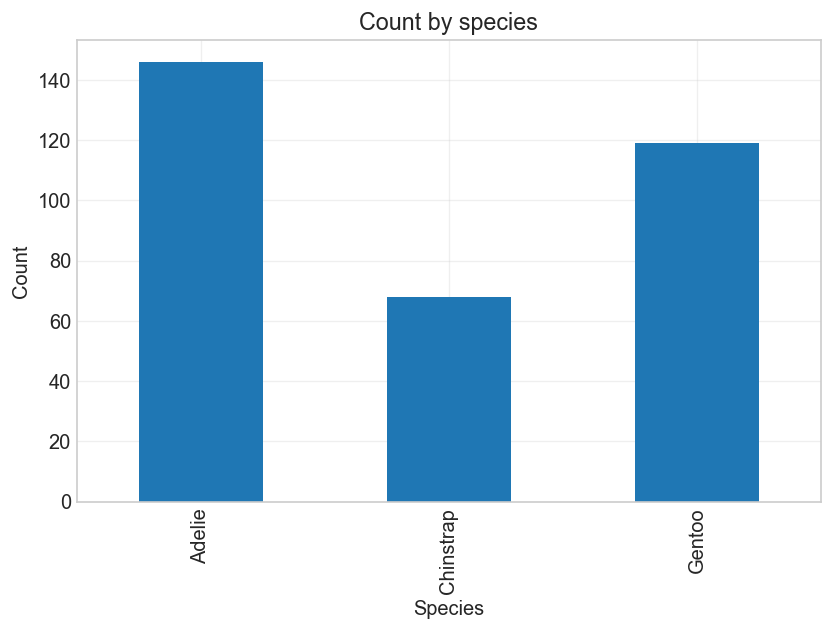

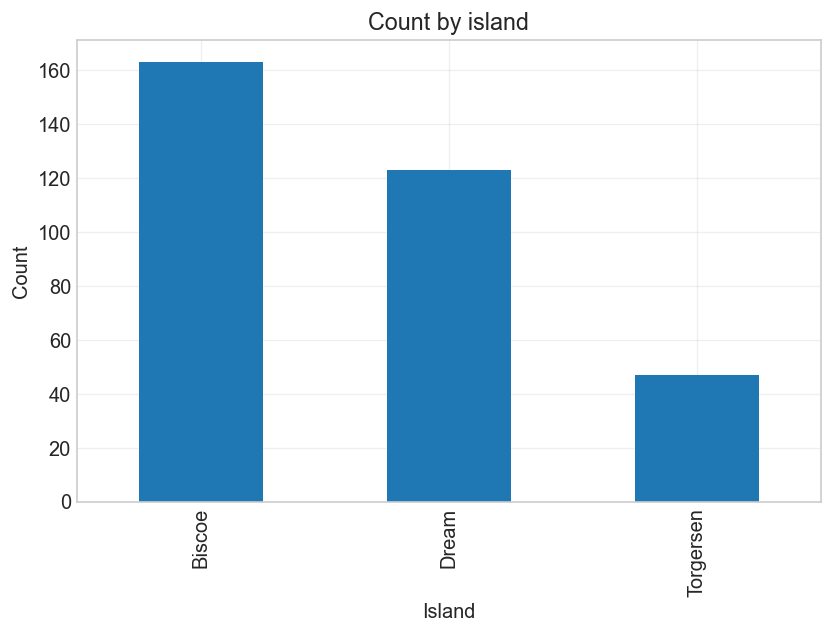

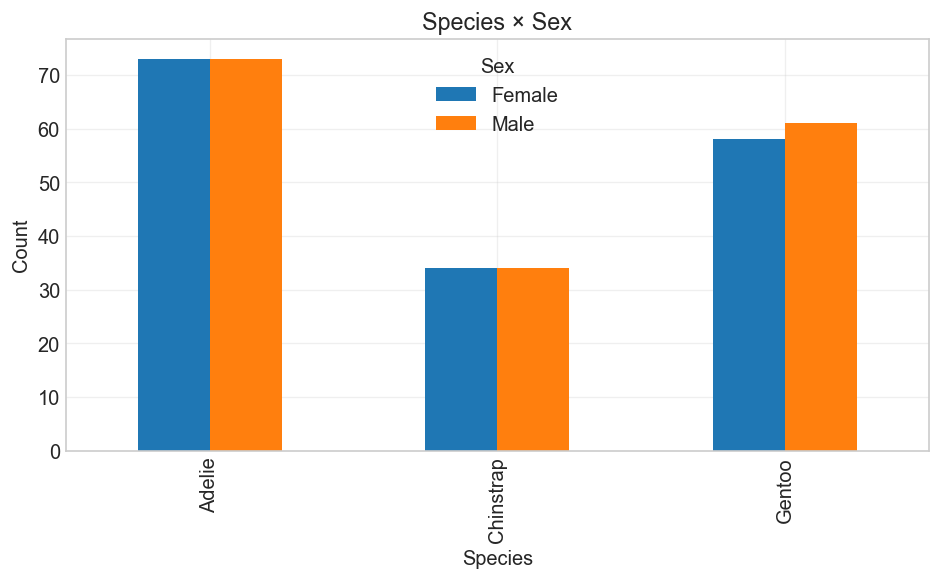

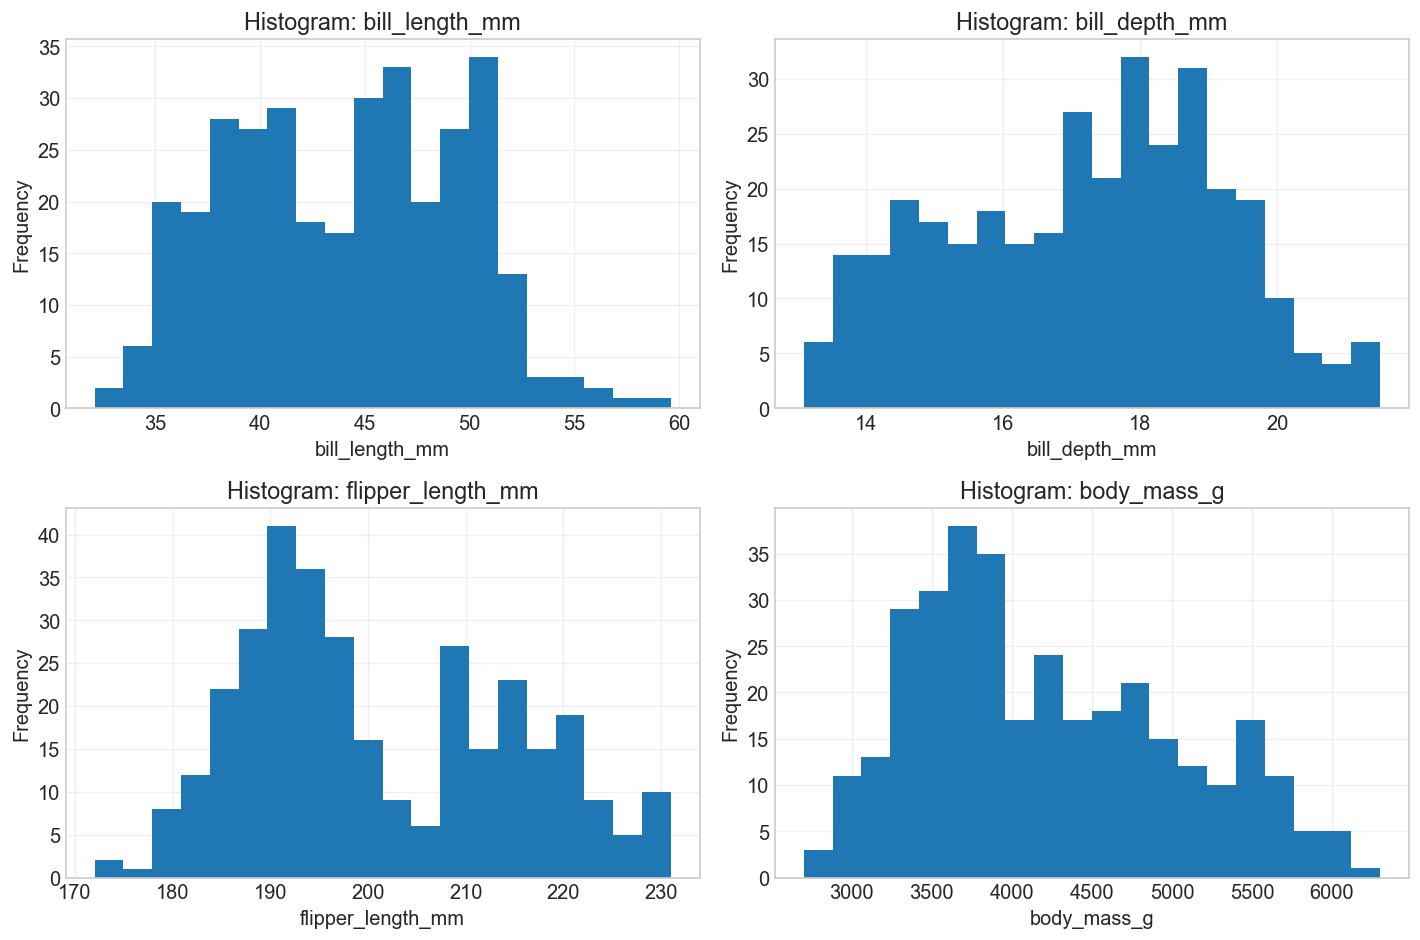

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.frameon": False,
    "grid.alpha": 0.3,
    "font.size": 12,
    "figure.dpi": 120,
})

def load_penguins():
    try:
        import seaborn as sns
        df = sns.load_dataset("penguins")
        if df is None or df.empty:
            raise RuntimeError("Empty penguins from seaborn.")
    except Exception:
        url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
        df = pd.read_csv(url)
    needed = ["species","island","sex","bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]
    return df.dropna(subset=needed).copy()

df = load_penguins()
for c in ["species", "island", "sex"]:
    df[c] = df[c].astype("category")

print(f"Rows: {len(df)}, Columns: {df.shape[1]}")
display(df.head())
display(df.describe(include='all'))

# Species count
ax = df["species"].value_counts().sort_index().plot(kind="bar")
ax.set(title="Count by species", xlabel="Species", ylabel="Count")
plt.show()

# Island count
ax = df["island"].value_counts().sort_index().plot(kind="bar")
ax.set(title="Count by island", xlabel="Island", ylabel="Count")
plt.show()

# Species x Sex (grouped)
ct = pd.crosstab(df["species"], df["sex"])
ax = ct.plot(kind="bar")
ax.set(title="Species × Sex", xlabel="Species", ylabel="Count")
ax.legend(title="Sex")
plt.tight_layout()
plt.show()

# Histograms
num_cols = ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=20)
    axes[i].set(title=f"Histogram: {col}", xlabel=col, ylabel="Frequency")
plt.tight_layout()
plt.show()

## Task 1 — Simple Linear Regression (t-stat & $R^2$) (3 points)
For the first task, you need to predict **body_mass_g** from **flipper_length_mm** using **closed-form formulas**.

**You will need the following:**
1) Coefficient estimates: $\hat\beta_1 = \frac{\sum (x_i-\bar x)(y_i-\bar y)}{\sum (x_i-\bar x)^2}$ and $\hat\beta_0=\bar y-\hat\beta_1 \bar x$.  
2) Residuals: $RSS=\sum e_i^2$, $s^2 = RSS/(n-2)$.  
3) Standard error $\mathrm{SE}(\hat\beta_1) = s/\sqrt{\sum (x_i-\bar x)^2}$ and **t-statistic** $t=\hat\beta_1/\mathrm{SE}(\hat\beta_1)$. (Compute p-value via t-CDF or table: Use the function `t_pvalue` from the first cell)  
4) The $R^2$ statistic: **$R^2 = 1 - RSS/TSS$**.  
5) Finally, you need to make a scatter with the fitted line and a **95% CI band** for the mean.

You can make use of the functions defined in the first cell when needed.

beta1=50.1533, t=32.562, R^2=0.762


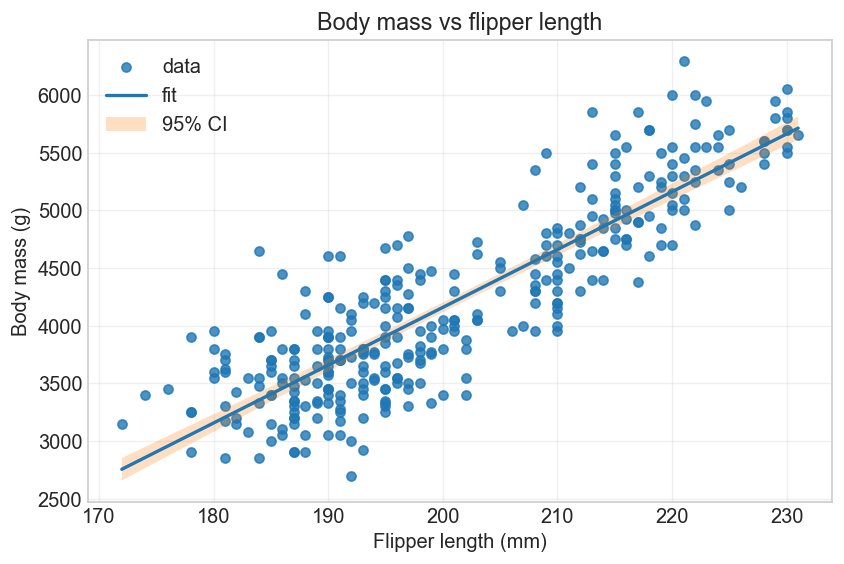

In [3]:
x = df["flipper_length_mm"].to_numpy()
y = df["body_mass_g"].to_numpy()
n = len(y)

# TODO: xbar, ybar
xbar = x.mean()
ybar = y.mean()

# TODO: Sxx, Sxy, beta1_hat, beta0_hat
Sxx = np.sum((x - xbar)**2)  #the sum of the squared x_i - x_mean
Sxy = np.sum((x-xbar)*(y-ybar))  #the sum of (x_i - x_mean)(y_i - y_mean) 
beta1 = Sxy/Sxx  #the w in y = wx + b
# Be super careful here, do not make the order wrong, or the result is meaningless
beta0 = ybar - beta1 * xbar

# TODO: predictions, residuals, RSS, s2
yhat = beta0 + beta1*x
e = y - yhat
RSS = np.sum(e**2)
s2 = RSS / (n - 2)  #Be careful the s2 here is s^2 there is no s1

# TODO: SE1 := SE_beta1, t_stat, TSS, R2
SE1 = np.sqrt(s2) / np.sqrt(Sxx) 
t_stat = beta1 / SE1
TSS = np.sum((y - ybar)**2)
R2 = 1 - RSS/TSS

print(f"beta1={beta1:.4f}, t={t_stat:.3f}, R^2={R2:.3f}")

# 95% CI band for mean
xs = np.linspace(x.min(), x.max(), 200)
ymean = beta0 + beta1*xs
s = np.sqrt(s2)
se_mean = s * np.sqrt(1/n + (xs - xbar)**2 / Sxx)
tcrit = 2.0 if tdist is None else tdist.ppf(0.975, df=n-2)
upper = ymean + tcrit * se_mean
lower = ymean - tcrit * se_mean

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.8, s=30, label="data")
ax.plot(xs, ymean, lw=2, label="fit")
ax.fill_between(xs, lower, upper, alpha=0.25, label="95% CI")
ax.set(title="Body mass vs flipper length", xlabel="Flipper length (mm)", ylabel="Body mass (g)")
ax.legend()
plt.show()

## Task 2 — Multiple Regression and Hypothesis Testing (3 points)
Predict **body_mass_g** using **bill_length_mm**, **bill_depth_mm**, **flipper_length_mm**.

**For this task, you need to do the following:**
1) Build $X = [\mathbf{1},\ \text{bill\_length},\ \text{bill\_depth},\ \text{flipper\_length}]$.  
2) Compute $\hat\beta = (X^\top X)^{-1}X^\top y$; fitted $\hat y$, residuals, $RSS$, $R^2$, $\text{adj. }R^2$.  
3) Compute the **overall $F$-statistic** using $F = \frac{(R^2/p)}{(1-R^2)/(n-p-1)}$.  
4) Draw a neat **correlation heatmap** for the 3 predictors + body\_mass\_g.

R^2=0.764   Overall F=354.90  p=1.1102230246251565e-16


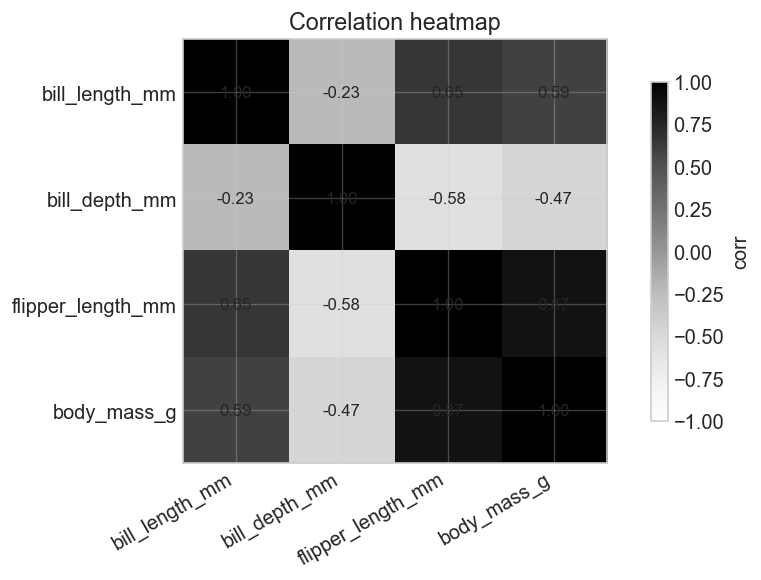

In [4]:
y = df["body_mass_g"].to_numpy()
X = np.column_stack([
    np.ones(len(df)),  #this beta_0 
    df["bill_length_mm"].to_numpy(),
    df["bill_depth_mm"].to_numpy(),
    df["flipper_length_mm"].to_numpy(),
])
n, k = X.shape 
p = k - 1

# TODO: compute the following quantities.
XtX = X.T @ X  #this is X^TX, the shape is k*k
XtX_inv = np.linalg.inv(XtX)
beta = XtX_inv @ (X.T @ y)  # Be careful with the capital/lowercase letter
yhat = X @ beta 
resid = y - yhat

RSS = float(resid @ resid)
s2 = RSS / (n - k)
covb = s2 * XtX_inv
SE = np.sqrt(np.diag(covb))
R2 = 1 - RSS / ((y - y.mean())**2).sum()

def ols_fit(X, y):
    return {"beta": beta, "yhat": yhat, "resid": resid, "RSS": RSS, "s2": s2, "SE": SE, "R2": R2, "XtX_inv": XtX_inv}

out = ols_fit(X, y)

# TODO: Compute F statistic.
F = (R2 /p) / ((1 - R2) / (n - p - 1))
pval = f_pvalue(F, p, n - p - 1)
print(f"R^2={R2:.3f}   Overall F={F:.2f}  p={pval}")

# Correlation heatmap
cols = ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]
M = df[cols].to_numpy()
C = np.corrcoef(M, rowvar=False)
fig, ax = plt.subplots()
im = ax.imshow(C, vmin=-1, vmax=1)
ax.set_xticks(range(len(cols))); ax.set_xticklabels(cols, rotation=30, ha="right")
ax.set_yticks(range(len(cols))); ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{C[i, j]:.2f}", ha="center", va="center", fontsize=10)
ax.set_title("Correlation heatmap")
fig.colorbar(im, ax=ax, shrink=0.8, label="corr")
plt.tight_layout()
plt.show()

## Task 3 — Add a Categorical Predictor (Species) (2 points)
Extend Task 2 by adding **species** via **dummy variables** (drop one level). Compare models with a **nested $F$-test**.

**Do this:**
1) Build **reduced** $X_r$ as in Task 2; build **full** $X_f = [X_r,\ \text{dummies for species (drop first)}]$.  
2) Fit both via $(X^\top X)^{-1}X^\top y$; compute $RSS_r$, $RSS_f$.  
3) Compute $F = \frac{(RSS_r - RSS_f)/(df_r - df_f)}{RSS_f/(n - df_f)}$ and its p-value.  
4) Plot flipper length vs body mass with **per-species fitted lines** (use Task-1 formulas within each species).

/var/folders/qf/jx2914td3fz8h9053dchwtlm0000gn/T/ipykernel_69099/2178953018.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for sp, sub in df.groupby("species"):


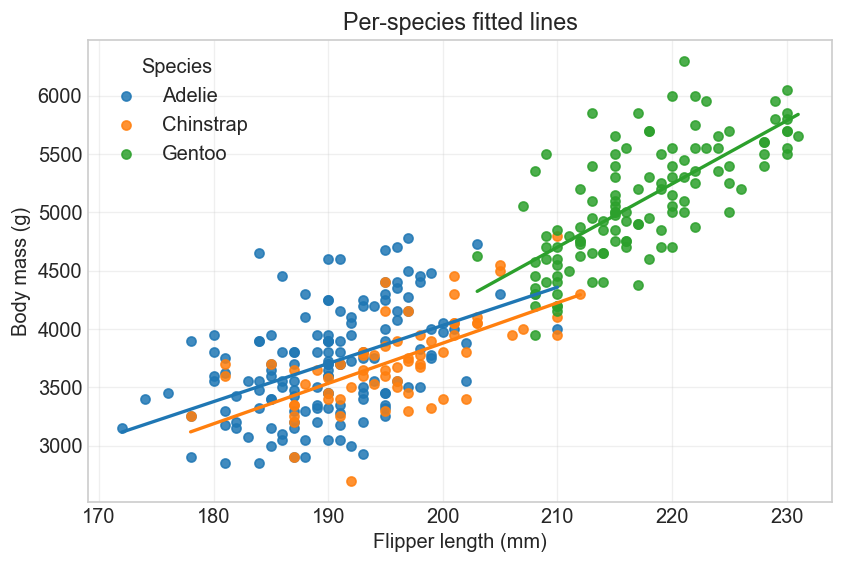

In [5]:
y = df["body_mass_g"].to_numpy()
Xr = np.column_stack([
    np.ones(len(df)),
    df["bill_length_mm"].to_numpy(),
    df["bill_depth_mm"].to_numpy(),
    df["flipper_length_mm"].to_numpy(),
])
# TODO: species dummies (drop first)
dums = pd.get_dummies(df["species"], drop_first=True).to_numpy()


Xf = np.column_stack([Xr, dums])

# Fit reduced & full
beta_r = np.linalg.inv(Xr.T @ Xr) @ (Xr.T @ y)
beta_f = np.linalg.inv(Xf.T @ Xf) @ (Xf.T @ y)

e_r = y - Xr @ beta_r
e_f = y - Xf @ beta_f
RSS_r = float(e_r @ e_r)
RSS_f = float(e_f @ e_f)

n = len(y)
dfr = Xr.shape[1]  # parameters including intercept
dff = Xf.shape[1]

# TODO: nested F-statistic and p-value
F = ((RSS_r - RSS_f) / (dff - dfr)) / (RSS_f / (n-dff))
pval = f_pvalue(F, dff - dfr, n - dff) 

#=============================================
#try:
    #from scipy.stats import f
    #pval = 1 - f.cdf(F, dff - dfr, n - dff)
#except Exception:
    #pval = None
#print(f"Nested F={F:.2f}  p={pval}")
# they give us the pre-defined function, no need to do it ourselves
#=============================================

# Per-species lines
fig, ax = plt.subplots()
for sp, sub in df.groupby("species"):
    x = sub["flipper_length_mm"].to_numpy()
    ysp = sub["body_mass_g"].to_numpy()
    slope, intercept = np.polyfit(x, ysp, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    ax.scatter(x, ysp, alpha=0.85, s=30, label=str(sp))
    ax.plot(xs, intercept + slope*xs, lw=2)

ax.set(title="Per-species fitted lines",
xlabel="Flipper length (mm)", ylabel="Body mass (g)")
ax.legend(title="Species")
plt.show()

## Task 4 — KNN Regression (1D, LOOCV) (1 point)
Use **k-nearest neighbors regression** to predict **body_mass_g** from **flipper_length_mm** (one feature). 

**For this task, you need to do the following:**
1) Complete the function `knn_regress_predict(q, x_train, y_train, k)` that returns the average $y$ of the $k$ nearest $x$ to query $q$ (Euclidean distance).  
2) Perform **leave-one-out cross-validation (LOOCV)** for odd $k \in \{1,3,\dots,25\}$ and plot the **MSE vs k**.
3) Plot the MSE vs k nieghbors. 

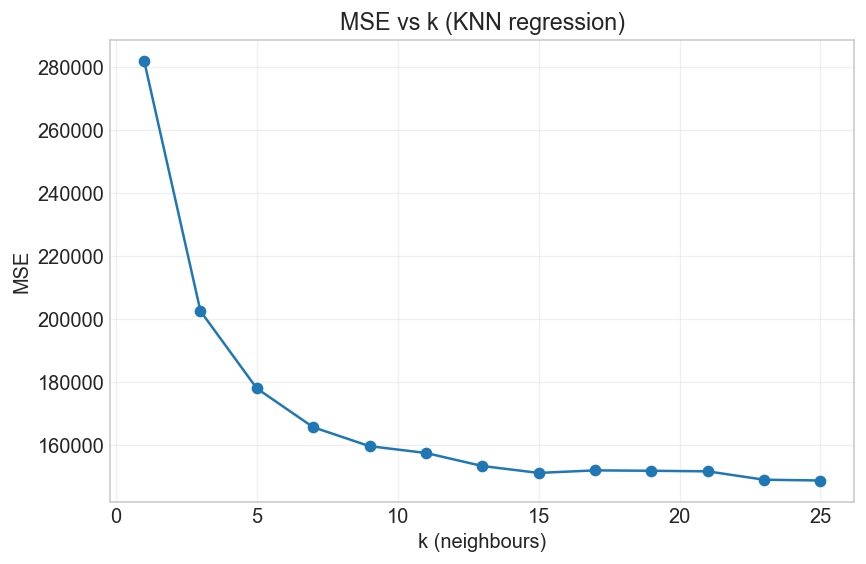

In [6]:
x = df["flipper_length_mm"].to_numpy()
y = df["body_mass_g"].to_numpy()
n = len(y)

# TODO: complete the following function.
def knn_regress_predict(q, x_train, y_train, k):
    dists = np.abs(x_train - q)
    idx = np.argsort(dists)[:k]
    return y_train[idx].mean()

ks = list(range(1, 26, 2))
mse = []
for k in ks:
    preds = np.empty(n)
    for i in range(n):
        mask = np.ones(n, dtype=bool)
        mask[i] = False
        preds[i] = knn_regress_predict(x[i], x[mask], y[mask], k)
    mse.append(np.mean((preds - y)**2))

# Plot MSE vs k
fig, ax = plt.subplots()
ax.plot(ks, mse, marker="o")
ax.set(title="MSE vs k (KNN regression)",
       xlabel="k (neighbours)", ylabel="MSE")
plt.show()

## Task 5 — Interpretation of the plots (1 point)

Comment on the LOOCV loss curve! What is a reasonable value for $k$ if we want the loss to be less than $60\%$ of what it was for $k=1$?

Denote the value of $k$ you picked with $k^*$. Visualise the fitted line for this value below. 

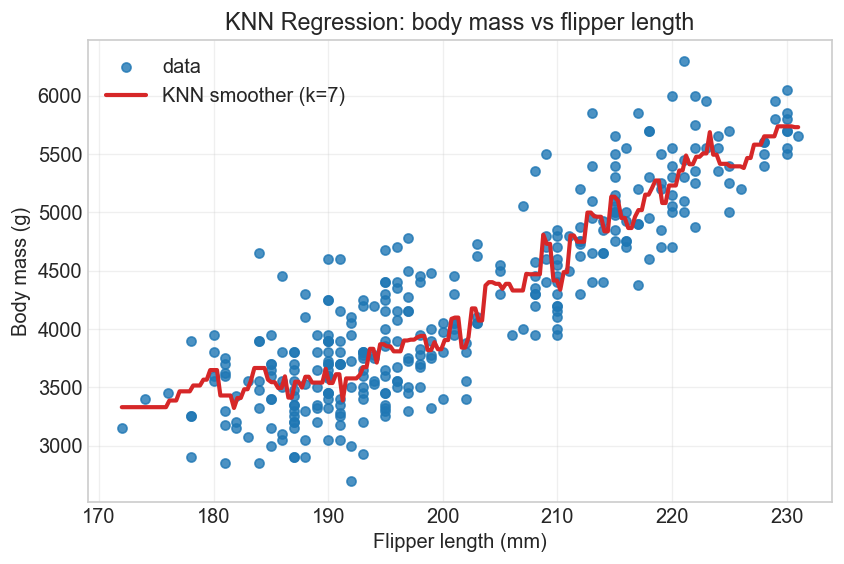

In [7]:
# Plot KNN smoother with k*
# Calculate MSE
mse_k1 = mse[0]
target_mse = 0.6*mse_k1

k_star = None
for i, k in enumerate(ks):
    if mse[i] < target_mse:
        k_star = k
        break
        
xs = np.linspace(x.min(), x.max(), 200)
yhat = np.array([knn_regress_predict(q, x, y, k_star) for q in xs])

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.8, s=30, color="C0", label="data")            
ax.plot(xs, yhat, lw=2.5, color="C3", label=f"KNN smoother (k={k_star})")
ax.set(title="KNN Regression: body mass vs flipper length",
       xlabel="Flipper length (mm)", ylabel="Body mass (g)")
ax.legend()
plt.show()

### Task 5: Interpretation

**Finding k*:**
At k=1, MSE = 280,796. The 60% threshold is 168,478.
I chose k* = 7 because it's the first k where MSE (159,720) drops 
below this threshold.

**What the curve shows:**
- At k=1: MSE is very high (overfitting)
- As k increases， MSE decreases quickly
- After k=7， MSE becomes more stable

This pattern makes sense because with k=1, each prediction uses only 
the nearest neighbour, which is too sensitive to noise. With k=7, we 
average over 7 neighbours, giving more stable predictions.

**The KNN fitted line (k=7):**
The red line shows the relationship between flipper length and body 
mass. The line goes up from left to right, which matches the data 
pattern: penguins with longer flippers tend to be heavier.

The line is not perfectly smooth because KNN predictions change as 
the nearest neighbours change. This is normal for KNN regression.